In [53]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import module_joaquin as mod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
df = pd.read_excel("data/USD_SOFR.xlsx", index_col=0, header=0)
df.dropna(inplace=True)
df.head()

,USD1y1y,USD2y1y,USD3y1y,USD4y1y,USD5y2y,USD7y3y,USD10y5y,USD15y5y,USD20y5y,USD25y5y
Trade Day,,,,,,,,,,
2011-09-27,0.177201,0.613752,1.364864,2.038994,2.655216,3.057123,3.349836,3.160193,3.063415,2.944442
2011-09-28,0.181141,0.602388,1.394476,2.021346,2.639105,3.067483,3.334938,3.143473,3.047186,2.956431
2011-09-29,0.192427,0.678039,1.405417,2.085105,2.652564,3.058120,3.321548,3.118247,3.020588,2.954893
2011-09-30,0.193416,0.635942,1.323026,1.946972,2.605848,2.920937,3.154124,2.940650,2.832992,2.759629
2011-10-03,0.179286,0.588597,1.215862,1.801201,2.345519,2.704160,2.933541,2.733042,2.631103,2.530194


In [55]:
# Go to decimal scale (1bp = 0.0001; 1% = 0.01)
train_df = df[df.index < "2020-01-01"] * 0.01
test_df = df[~(df.index < "2020-01-01")] * 0.01

In [56]:
# compute the PCA score time-series.
# Note that PCA windows are being hyperparameters of the trading model.
train_scores, train_pca = mod.rolling_pca(train_df,
                                          corr_window_size=252,
                                          vol_window_size=60,
                                          recalibration_period=30)

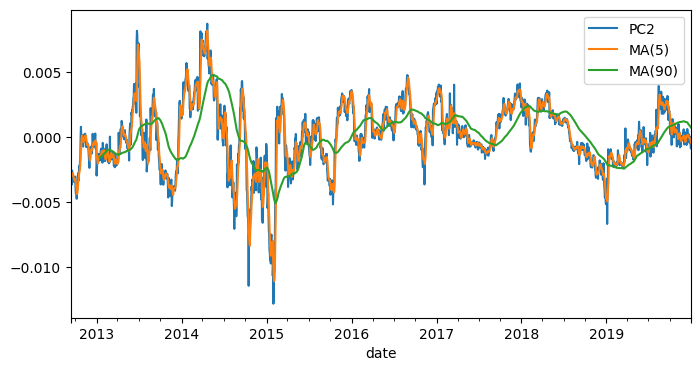

In [57]:
# Short visualization
short_ma_window = 5
long_ma_window = 90
short_ma = train_scores["PC2"].rolling(short_ma_window).mean()
long_ma = train_scores["PC2"].rolling(long_ma_window).mean()

plt.figure(figsize=(8, 4))
train_scores["PC2"].plot(label="PC2")
short_ma.plot(label=f"MA({short_ma_window})")
long_ma.plot(label=f"MA({long_ma_window})")
plt.legend()
plt.show()

### Optimizing MA startegy parameters

In [58]:
portfolio = np.array([
    -1.0, #1Y
    0,    #2Y
    0,    #3Y
    0,    #4Y
    0,    #5Y
    0,    #7Y
    1.0,  #10Y
    0,    #15Y
    0,    #20Y
    0,    #25Y
])


In [59]:
from scipy.optimize import brute

def neg_ema_strat_sharpe(X):
    short, long, threshold = X
    # enforce integer EMAs & simple constraints
    short = int(round(short))
    long  = int(round(long))
    threshold = float(threshold)

    if short < 1 or long <= short:
        return 1e6
    sharpe = mod.ema_strat_trading_sharpe(train_scores, train_pca, train_df, portfolio, short, long, threshold)
    # If your ema_strat_sharpe returns -inf on bad configs, penalize
    if not np.isfinite(sharpe):
        return 1e6

    return -sharpe   # because we want to MAXIMIZE the Sharpe

# slice(start, stop, step) — stop is INCLUDED by brute
rranges = (
    slice(5, 31, 5),        # short: 5,10,15,20,25,30
    slice(50, 201, 10),     # long: 50,60,...,200
    slice(0.0, 0.01000001, 5e-5),  # threshold: pace 0.5 bp
)

best_x, best_f, grid_vals, grid_sharpes = brute(
                                    neg_ema_strat_sharpe,
                                    rranges,
                                    full_output=True,
                                    finish=None,
                                )

best_short     = int(round(best_x[0]))
best_long      = int(round(best_x[1]))
best_threshold = float(best_x[2])
best_sharpe    = -best_f

print("Best params via brute:")
print("  short     =", best_short)
print("  long      =", best_long)
print("  threshold =", best_threshold)
print("  Sharpe    =", best_sharpe)

Best params via brute:
  short     = 20
  long      = 70
  threshold = 0.004200000000000001
  Sharpe    = 0.7771218525287319


<Axes: xlabel='date'>

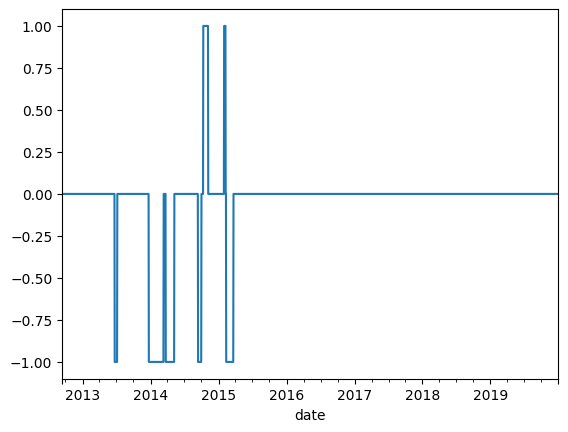

In [70]:
trades, df2 = mod.ema_strat(train_scores,
                            train_pca,
                            train_df,
                            portfolio,
                            short=20, long=70, threshold=0.0042)
df2["position"].plot()

In [71]:
df_trades = pd.DataFrame(trades)
df_trades.drop(columns=["pc_loading", "portfolio","mtm"], inplace=True)
df_trades

,entry_date,exit_date,position,days,pnl,vol
0,2013-06-21,2013-07-05,-1,11,-5.41,6.283
1,2013-12-23,2014-03-12,-1,58,34.60,3.705
2,2014-03-24,2014-05-08,-1,34,17.92,4.369
3,2014-09-12,2014-10-01,-1,14,31.47,4.740
4,2014-10-10,2014-11-06,1,20,-1.08,4.094
5,2015-01-30,2015-02-09,1,7,-4.87,14.400
6,2015-02-11,2015-03-23,-1,29,-6.57,5.494


In [79]:
sharpe = mod.ema_strat_trading_sharpe(train_scores, train_pca, train_df, portfolio,
                                            short=20, long=70, threshold=0.0030)
sharpe

np.float64(0.0920504701273038)

### Out-of-sample Testing

In [80]:
portfolio = np.array([
    -1.0, #1Y
    0,    #2Y
    0,    #3Y
    0,    #4Y
    0,    #5Y
    0,    #7Y
    1.0,  #10Y
    0,    #15Y
    0,    #20Y
    0,    #25Y
])

test_scores, test_pca = mod.rolling_pca(test_df,
                                          corr_window_size=252,
                                          vol_window_size=60,
                                          recalibration_period=30)

trades_test, _ = mod.ema_strat(test_scores,
                            test_pca,
                            test_df,
                            portfolio,
                            short=20, long=70, threshold=0.0030)

df_trades_test = pd.DataFrame(trades_test).drop(columns=["pc_loading", "portfolio","mtm"])
df_trades_test

,entry_date,exit_date,position,days,pnl,vol
0,2021-10-28,2021-11-18,1,16,-1.21,5.622
1,2021-12-30,2022-03-02,-1,45,46.76,6.499
2,2022-03-07,2022-03-09,1,3,-15.18,0.547
3,2022-03-14,2022-03-24,-1,9,34.03,7.649
4,2022-03-31,2022-04-08,1,7,-11.60,11.954
5,2022-04-12,2022-05-05,-1,18,-9.63,11.373
6,2022-05-06,2022-07-01,1,41,60.53,10.787
7,2022-07-06,2022-07-14,-1,7,34.66,9.455
8,2022-08-04,2022-10-21,1,57,-59.65,11.059
9,2022-10-25,2022-11-03,-1,8,44.67,10.066


In [82]:
print(f"PnL Test: {df_trades_test["pnl"].sum():.2f} bps")
sharpe_test = mod.ema_strat_trading_sharpe(test_scores, test_pca, test_df, portfolio,
                                            short=20, long=70, threshold=0.0030)

print(f"Test Trading SR: {sharpe_test:.3f}")



PnL Test: 314.62 bps
Test Trading SR: 1.104
